In [ ]:
#import shutil

import torchvision
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as func
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.optim import lr_scheduler
from torchvision.models import resnet50, vgg11, densenet121, ResNet50_Weights, alexnet

import os
import torch
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch.optim as optim
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to the folder containing the images in Google Drive
training_folder_path = '/content/drive/MyDrive/Assignment2/harddrive.csv'

dataset = pd.read_csv(training_folder_path)
dataset

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179290,2016-04-29,MJ1311YNG3G5NA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,100.0,0.0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179291,2016-04-29,Z3016V0V,ST4000DM000,1.976651e-311,0,117,121623392,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179292,2016-04-29,MJ1323YNG1LZJC,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,100.0,0.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179293,2016-04-29,S300YQXW,ST4000DM000,1.976651e-311,0,118,179727616,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### It's challenging to plot due to the fact that the 90 fields that start with Smart are "some" statistics that are given by the manufacturer. It is not clear what these stats represent.

### Number of devices under different models

In [ ]:
df = pd.DataFrame(dataset[['model', 'serial_number']].groupby('model')['serial_number'].nunique())

fig, ax = plt.subplots(figsize = (20, 5))

plt.bar(df.index, df.serial_number)

ax.set_ylabel('# devices under different models', fontsize = 9)
plt.xticks(fontsize = 9, rotation=90)
plt.yticks(fontsize = 9)

plt.show()



#### ST4000MD000 - is the most used/sold hard drive in the dataset

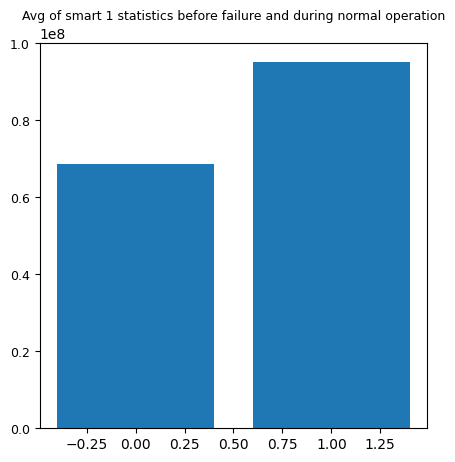

In [ ]:
df = pd.DataFrame(dataset[['failure', 'smart_1_raw']].groupby('failure').mean('serial_number'))

fig, ax = plt.subplots(figsize = (5, 5))

plt.bar(df.index, df.smart_1_raw)
ax.set_title('Avg of smart 1 statistics before failure and during normal operation', fontsize = 9)
plt.yticks(fontsize = 9)

plt.show()



### It's notable that smart 1 values are way higher just before failure than normal operation

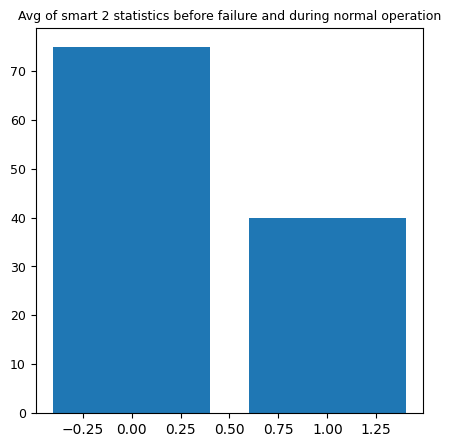

In [ ]:
df = pd.DataFrame(dataset[['failure', 'smart_2_raw']].groupby('failure').mean('serial_number'))

fig, ax = plt.subplots(figsize = (5, 5))

plt.bar(df.index, df.smart_2_raw)
ax.set_title('Avg of smart 2 statistics before failure and during normal operation', fontsize = 9)
plt.yticks(fontsize = 9)

plt.show()



### It's notable that smart 2 values are way lower just before failure than normal operation

In [ ]:
stat = pd.DataFrame(dataset.isna().sum())
stat

,0
date,0
serial_number,0
model,0
capacity_bytes,0
failure,0
...,...
smart_252_raw,3176460
smart_254_normalized,3171360
smart_254_raw,3171360
smart_255_normalized,3179295


In [ ]:
colsToRemove = [col for col in dataset.columns if col.find('normalized') != -1]

In [ ]:
cols_to_save = [col for col in dataset.columns if (col not in stat[stat[0] > 10000].index) and (col.find('normalized') != -1)]

std_sc = StandardScaler()
std_sc.fit(dataset[cols_to_save])
dataset[cols_to_save] = std_sc.transform(dataset[cols_to_save])

#cols_to_save.append('date')

cols_to_save.append('capacity_bytes')
cols_to_save.append('failure')

df = dataset[cols_to_save]
df.head()

,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_192_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,capacity_bytes,failure
0,-0.650963,2.016065,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,1.659218,-0.215773,-0.111824,0.012003,1.482490e-311,0
1,0.043732,-0.497109,0.011837,-0.214845,-1.352364,0.954574,-0.10236,0.004082,-0.208676,-0.793888,-0.215773,-0.111824,0.012003,1.976651e-311,0
2,-0.650963,1.000101,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,1.626216,-0.215773,-0.111824,0.012003,1.482490e-311,0
3,-0.650963,1.695235,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,0.999189,-0.215773,-0.111824,0.012003,1.482490e-311,0
4,4.692844,3.727163,0.011837,3.965006,0.312956,-0.954488,-0.10236,0.004082,4.122713,0.207155,3.967025,-0.111824,0.012003,1.482490e-311,0


In [ ]:
df.isna().sum()

smart_1_normalized         0
smart_3_normalized         0
smart_4_normalized         0
smart_5_normalized         0
smart_7_normalized         0
smart_9_normalized         0
smart_10_normalized        0
smart_12_normalized        0
smart_192_normalized    9581
smart_194_normalized      52
smart_197_normalized       0
smart_198_normalized       0
smart_199_normalized       0
capacity_bytes             0
failure                    0
dtype: int64

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.head()

,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_192_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,capacity_bytes,failure
0,-0.650963,2.016065,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,1.659218,-0.215773,-0.111824,0.012003,1.482490e-311,0
1,0.043732,-0.497109,0.011837,-0.214845,-1.352364,0.954574,-0.10236,0.004082,-0.208676,-0.793888,-0.215773,-0.111824,0.012003,1.976651e-311,0
2,-0.650963,1.000101,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,1.626216,-0.215773,-0.111824,0.012003,1.482490e-311,0
3,-0.650963,1.695235,0.011837,-0.214845,0.312956,0.596625,-0.10236,0.004082,-0.208676,0.999189,-0.215773,-0.111824,0.012003,1.482490e-311,0
4,4.692844,3.727163,0.011837,3.965006,0.312956,-0.954488,-0.10236,0.004082,4.122713,0.207155,3.967025,-0.111824,0.012003,1.482490e-311,0


In [ ]:
df['failure'].value_counts()

0    3169451
1        211
Name: failure, dtype: int64

#### Unbalanced data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['failure'], axis=1), df['failure'], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train.to_numpy())
y_train = torch.tensor(y_train.to_numpy())

X_test = torch.tensor(X_test.to_numpy())
y_test = torch.tensor(y_test.to_numpy())

X_val = torch.tensor(X_val.to_numpy())
y_val = torch.tensor(y_val.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, input_dim, middle):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, middle)
        self.fc_logvar = nn.Linear(32, middle)

        self.decoder = nn.Sequential(
            nn.Linear(middle, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        output = self.decode(z)
        return output, mu, logvar



In [ ]:
def train(model, optimizer, criterion, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    outputs = []
    train_loss = []
    val_loss = []

    overall_losses = []
    for epoch in range(num_epochs):
        loss_values = []
        model.train()

        for train_data, _ in train_loader:
            train_data = train_data.float()

            recon, mean, log_var = model(train_data)

            optimizer.zero_grad()
            loss = criterion(recon, train_data)
            kl_div_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            total_loss = loss + kl_div_loss

            loss_values.append(total_loss.item())
            overall_losses.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

        loss_values = round(sum(loss_values)/len(loss_values), 4)
        train_loss.append(loss_values)

        # validate
        loss_values = []
        for val_data, _ in val_loader:
            val_data = val_data.float()

            recon, mean, log_var = model(val_data)
            loss = criterion(recon, val_data)

            kl_div_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            total_loss = loss + kl_div_loss
            loss_values.append(total_loss.item())

        loss_values = round(sum(loss_values)/len(loss_values), 4)

        val_loss.append(loss_values)

        print(f'VAE Epoch: {epoch}/{num_epochs} training loss {train_loss[-1]}, validation loss {val_loss[-1]}')

    plt.plot(range(0, epoch + 1), train_loss, label='Training Loss')
    plt.plot(range(0, epoch + 1), val_loss, label='Validation Loss')
    plt.legend(loc = 'lower right')

    return model, overall_losses


VAE Epoch: 0/10 training loss 1.0212, validation loss 0.8688
VAE Epoch: 1/10 training loss 0.8882, validation loss 0.8684
VAE Epoch: 2/10 training loss 0.8874, validation loss 0.8675
VAE Epoch: 3/10 training loss 0.8854, validation loss 0.8675
VAE Epoch: 4/10 training loss 0.8853, validation loss 0.8675
VAE Epoch: 5/10 training loss 0.8853, validation loss 0.8675
VAE Epoch: 6/10 training loss 0.8853, validation loss 0.8675
VAE Epoch: 7/10 training loss 0.8854, validation loss 0.8675
VAE Epoch: 8/10 training loss 0.8853, validation loss 0.8675
VAE Epoch: 9/10 training loss 0.8853, validation loss 0.8675


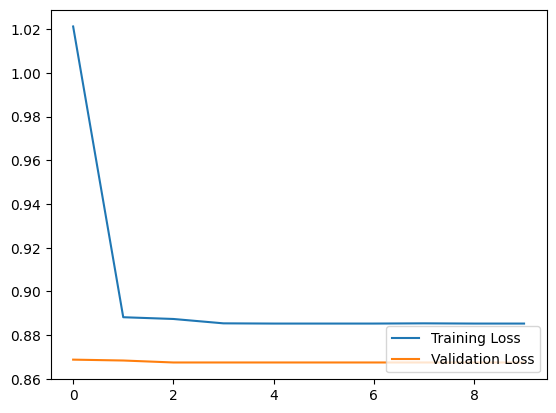

In [ ]:
vae_model = VAE(14, 10)
n_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001, weight_decay=1e-5)

vae_model, overall_loss  = train(vae_model, optimizer, criterion, num_epochs = n_epochs)


Reference links -

https://becominghuman.ai/variational-autoencoders-for-new-fruits-with-keras-and-pytorch-6d0cfc4eeabd

https://www.kaggle.com/code/lucfrachon/anomaly-detection-using-vaes

https://avandekleut.github.io/vae/

VAE Epoch: 0/10 training loss 0.9306, validation loss 0.8682
VAE Epoch: 1/10 training loss 0.8874, validation loss 0.8681
VAE Epoch: 2/10 training loss 0.8857, validation loss 0.8678
VAE Epoch: 3/10 training loss 0.8856, validation loss 0.8676
VAE Epoch: 4/10 training loss 0.8855, validation loss 0.8677
VAE Epoch: 5/10 training loss 0.8855, validation loss 0.8676
VAE Epoch: 6/10 training loss 0.8855, validation loss 0.8676
VAE Epoch: 7/10 training loss 0.8854, validation loss 0.8683
VAE Epoch: 8/10 training loss 0.8855, validation loss 0.8676
VAE Epoch: 9/10 training loss 0.8854, validation loss 0.8676


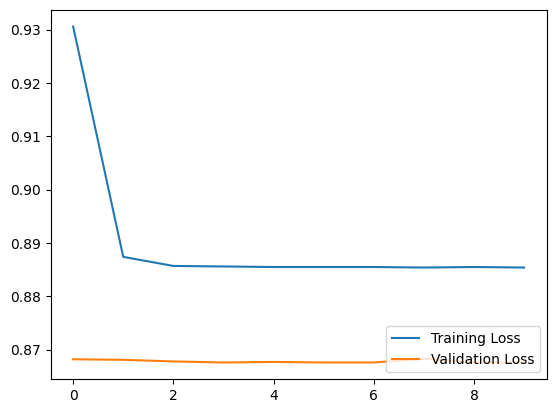

In [ ]:
class VAE_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, input_dim)

        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)


    def encode(self, x):
        out, (hidden, _) = self.encoder_lstm(x)
        hidden = hidden.repeat(1, self.repeat, 1)
        mu = self.mu(hidden)
        logvar = self.logvar(hidden)
        return mu, logvar

    def decode(self, z):
        output, _ = self.decoder_lstm(z)
        output = self.decoder_fc(output)
        return output

    def forward(self, x):
        self.repeat = x.shape[0]
        mu, logvar = self.encode(x)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        output = self.decode(z)
        return output.squeeze(), mu, logvar


lstm_model = VAE_LSTM(14, 32, 10)
n_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001, weight_decay=1e-5)
lstm_model, lstm_overall_loss  = train(lstm_model, optimizer, criterion, num_epochs = n_epochs)


In [ ]:
class VAE_Conv(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )

        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, input_dim, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        hidden = self.encoder(x.transpose(1, -2))
        self.shape = x.shape[0]
        latentshape = hidden.shape[1]

        print(hidden.shape)
        mu = self.mu(hidden)
        logvar = self.logvar(hidden)
        return mu, logvar

    def decode(self, z):
        z = z.unsqueeze(-1)
        output = self.decoder(z)
        return output.reshape(self.shape, 14)

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        decoded = self.decode(z)

        return decoded, mu, logvar

conv_model = VAE_Conv(14, 32, 10)
n_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.0001, weight_decay=1e-5)
#conv_model, conv_overall_loss  = train(conv_model, optimizer, criterion, num_epochs = n_epochs)

https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html

In [ ]:
torch.save(vae_model.state_dict(), 'VIJAYAVA_CKONDINO_assignment2_part4.pth')

In [ ]:
losses = torch.tensor(overall_loss)
mean_loss = torch.mean(losses)
std_loss = torch.std(losses)

threshold = mean_loss + (100 * std_loss)
print(mean_loss, std_loss, threshold)

tensor(0.8994) tensor(4.3472) tensor(435.6161)


In [ ]:
# detect anomaly
loss_values = []

for test_data, label in test_loader:
    test_data = test_data.float()

    recon, mean, log_var = vae_model(test_data)
    loss = criterion(recon, test_data)

    kl_div_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    total_loss = loss + kl_div_loss
    loss_values.append(total_loss.item())

    if total_loss > threshold:
        print("yes", label.item())

loss_values = round(sum(loss_values)/len(loss_values), 4)


yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
yes 0
